In [1]:
# import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from implementations import *
import SVM

### Prepare the data ###

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("/home/zewzhang/Course/ML/ML_course/projects/project1/data/dataset_to_release", sub_sample=True)

In [3]:
print(x_train.shape)
print(y_train.shape)

(6563, 321)
(6563,)


In [24]:
# threshold to keep the features
threshold_nan = 0.3
x_train_processed = x_train.copy()
x_train_processed = fillna_with_mean(x_train_processed, threshold=threshold_nan)
x_train_processed = standardize(x_train_processed)
x_train_processed_hinge = x_train_processed.copy()
x_train_processed = add_bias(x_train_processed)
# add a column of ones
x_train_processed, y_train_processed = data_augmentation(x_train_processed, y_train)
y_train_processed_hinge = y_train.copy()    
y_train_processed = process_y(y_train_processed)
print(np.isnan(x_train_processed).any())

False


In [5]:
print(x_train_processed.shape)
print(y_train_processed.shape)
print(np.sum(x_train_processed.std(axis=0) == 0))

(12004, 143)
(12004,)
1


In [6]:
x_train_processed_orig = x_train.copy()
x_train_processed_orig = fillna_with_mean(x_train_processed_orig, threshold=threshold_nan)
x_train_processed_orig = standardize(x_train_processed_orig)
x_train_processed_orig = add_bias(x_train_processed_orig)
# add a column of ones
y_train_processed_orig = y_train.copy()
y_train_processed_orig = process_y(y_train_processed_orig)
print(np.isnan(x_train_processed_orig).any())

False


In [7]:
print(x_train_processed_orig.shape)
print(y_train_processed_orig.shape)

(6563, 143)
(6563,)


In [8]:
## PCA feature selection 
threshold_nan_pca = 0.5
pre_train_data = x_train.copy()
pre_train_data = fillna_with_mean(pre_train_data, threshold=threshold_nan_pca)

x_pca, eig_vec, eig_val,weight = pca(pre_train_data, 100)
x_pca = standardize(x_pca)
x_pca = add_bias(x_pca)
x_train_processed_orig_pca = x_pca.copy()
x_pca, _ = data_augmentation(x_pca, y_train)
print(weight)

[ 1.17056338e-01+0.00000000e+00j  5.19817810e-02+0.00000000e+00j
  3.51028326e-02+0.00000000e+00j  3.10519268e-02+0.00000000e+00j
  2.79084523e-02+0.00000000e+00j  2.60579658e-02+0.00000000e+00j
  2.07247229e-02+0.00000000e+00j  2.01854996e-02+0.00000000e+00j
  1.97504477e-02+0.00000000e+00j  1.82827562e-02+0.00000000e+00j
  1.78592729e-02+0.00000000e+00j  1.75873812e-02+0.00000000e+00j
  1.63961497e-02+0.00000000e+00j  1.50021104e-02+0.00000000e+00j
  1.45288842e-02+0.00000000e+00j  1.43520448e-02+0.00000000e+00j
  1.28929996e-02+0.00000000e+00j  1.25382113e-02+0.00000000e+00j
  1.19441474e-02+0.00000000e+00j  1.14548177e-02+0.00000000e+00j
  1.12093145e-02+0.00000000e+00j  1.11791640e-02+0.00000000e+00j
  1.08731483e-02+0.00000000e+00j  1.05566411e-02+0.00000000e+00j
  1.01249886e-02+0.00000000e+00j  1.00281106e-02+0.00000000e+00j
  9.78736703e-03+0.00000000e+00j  9.37595682e-03+0.00000000e+00j
  9.15056134e-03+0.00000000e+00j  8.90260043e-03+0.00000000e+00j
  8.71822997e-03+0.000000

In [9]:
pre_train_data.shape

(6563, 174)

/home/zewzhang/miniconda3/envs/ML/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/zewzhang/miniconda3/envs/ML/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


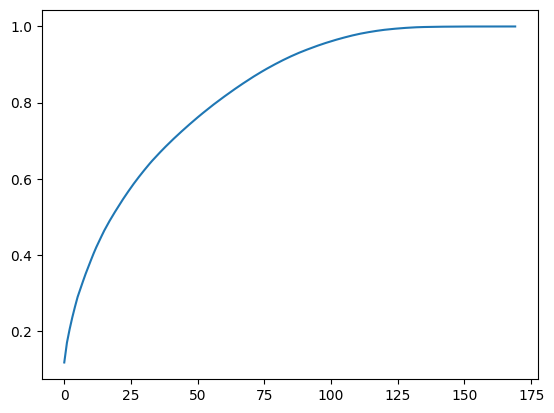

In [10]:
cummulation = np.cumsum(weight)
cummulation
plt.plot(cummulation)

In [11]:
x_pca.shape

(12004, 101)

### Experiment ###

In [12]:
## linear regression using all the features except for those having NaN values over 50% ##

initial_w = np.random.randn(x_train_processed.shape[1]) * 0.01
w, loss = mean_square_error_gd(y_train_processed, x_train_processed, initial_w, max_iters = 100, gamma=0.05)
y_pred = x_train_processed @ w
y_pred_mean = np.mean(y_pred)
predict_acc(x_train_processed_orig, y_train_processed_orig, w, logistic=False, threshold=y_pred_mean)
predict_f1(x_train_processed_orig, y_train_processed_orig, w, logistic=False, threshold=y_pred_mean)

GD iter. 0/99: loss=0.28378493642397645
GD iter. 10/99: loss=0.09787248294806823
GD iter. 20/99: loss=0.08422354520420035
GD iter. 30/99: loss=0.0789744153186847
GD iter. 40/99: loss=0.0767252868519264


GD iter. 50/99: loss=0.0756989520329858
GD iter. 60/99: loss=0.07520085063526796
GD iter. 70/99: loss=0.07494046523119388
GD iter. 80/99: loss=0.07479141651027899
GD iter. 90/99: loss=0.07469700899118516
The Accuracy is: 0.7539
The F1 score is: 0.3644
The precision is: 0.2338
The recall is: 0.8253


In [13]:
x_train_processed.shape

(12004, 143)

In [14]:
# logistic regression using all the features except for those having NaN values over 50% ##
initial_w = np.random.randn(x_train_processed.shape[1]) * 0.01
w, loss = logistic_regression(y_train_processed, x_train_processed, initial_w, max_iters=800, gamma=0.15)
predict_acc(x_train_processed_orig, y_train_processed_orig, w, logistic=False, threshold=0.85)
predict_f1(x_train_processed_orig, y_train_processed_orig, w, logistic=False, threshold=0.85)

GD iter. 0/799: loss=0.6909355818630069
GD iter. 1/799: loss=0.6108760742804626
GD iter. 2/799: loss=0.5779684725864976
GD iter. 3/799: loss=0.5611013979976893
GD iter. 4/799: loss=0.5508843542612606
GD iter. 5/799: loss=0.5438531878013491
GD iter. 6/799: loss=0.5385209017349654
GD iter. 7/799: loss=0.5341792298435389
GD iter. 8/799: loss=0.5304633165411469
GD iter. 9/799: loss=0.5271727750984119
GD iter. 10/799: loss=0.5241911684807654
GD iter. 11/799: loss=0.521447179598998
GD iter. 12/799: loss=0.5188948338474354
GD iter. 13/799: loss=0.5165029682604019
GD iter. 14/799: loss=0.5142494108799176
GD iter. 15/799: loss=0.5121176564809675
GD iter. 16/799: loss=0.5100949099230249
GD iter. 17/799: loss=0.5081709004499305
GD iter. 18/799: loss=0.5063371418242676
GD iter. 19/799: loss=0.5045864565175804
GD iter. 20/799: loss=0.5029126599938083
GD iter. 21/799: loss=0.5013103443923926
GD iter. 22/799: loss=0.49977472548019425


GD iter. 23/799: loss=0.49830153094373686
GD iter. 24/799: loss=0.49688691644554805
GD iter. 25/799: loss=0.49552740086080416
GD iter. 26/799: loss=0.49421981514370217
GD iter. 27/799: loss=0.4929612611473991
GD iter. 28/799: loss=0.4917490779008385
GD iter. 29/799: loss=0.4905808136026821
GD iter. 30/799: loss=0.48945420208863893
GD iter. 31/799: loss=0.4883671428610581
GD iter. 32/799: loss=0.48731768399790826
GD iter. 33/799: loss=0.48630400741871105
GD iter. 34/799: loss=0.4853244161004554
GD iter. 35/799: loss=0.4843773229214756
GD iter. 36/799: loss=0.4834612408750799
GD iter. 37/799: loss=0.48257477444354
GD iter. 38/799: loss=0.48171661196100696
GD iter. 39/799: loss=0.48088551882384506
GD iter. 40/799: loss=0.4800803314307571
GD iter. 41/799: loss=0.4792999517543161
GD iter. 42/799: loss=0.47854334246116625
GD iter. 43/799: loss=0.4778095225109692
GD iter. 44/799: loss=0.47709756317472385
GD iter. 45/799: loss=0.476406584421847
GD iter. 46/799: loss=0.4757357516326808
GD iter.

In [15]:
# logistic regression
initial_w = np.random.randn(x_train_processed.shape[1]) * 0.01
x_t, y_t, x_v, y_v = split_data(x_train_processed_orig, y_train_processed_orig, 0.8)
x_t, y_t = data_augmentation(x_t, y_t)
w, loss = reg_logistic_regression(y_t, x_t, lambda_=0.01, initial_w=initial_w, max_iters=500, gamma=0.15)
y_pred = (x_v @ w >= 0.85).astype(int)
# predict_acc(x_v, y_v, w, logistic=False, threshold=0.85)
# predict_f1(x_v, y_v, w, logistic=False, threshold=0.85)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

GD iter. 0/499: loss=0.696055437077474
GD iter. 1/499: loss=0.6140070182275016
GD iter. 2/499: loss=0.5793007369331515
GD iter. 3/499: loss=0.5617015637942935
GD iter. 4/499: loss=0.5511577807553913
GD iter. 5/499: loss=0.543946785314281
GD iter. 6/499: loss=0.5384952331598506
GD iter. 7/499: loss=0.5340644995280746
GD iter. 8/499: loss=0.5302780440720292
GD iter. 9/499: loss=0.5269303554203718
GD iter. 10/499: loss=0.523902283587119
GD iter. 11/499: loss=0.5211207330047702
GD iter. 12/499: loss=0.5185383528744661
GD iter. 13/499: loss=0.5161228180092293
GD iter. 14/499: loss=0.5138509440002619
GD iter. 15/499: loss=0.5117053407662869
GD iter. 16/499: loss=0.5096724455944445
GD iter. 17/499: loss=0.5077413287851396
GD iter. 18/499: loss=0.5059029441120507
GD iter. 19/499: loss=0.504149642270499
GD iter. 20/499: loss=0.5024748440162808
GD iter. 21/499: loss=0.5008728129818297
GD iter. 22/499: loss=0.4993384925280153
GD iter. 23/499: loss=0.49786738498153016
GD iter. 24/499: loss=0.49645

GD iter. 70/499: loss=0.463669178257393
GD iter. 71/499: loss=0.46331640847628486
GD iter. 72/499: loss=0.4629715587284988
GD iter. 73/499: loss=0.4626343872862444
GD iter. 74/499: loss=0.46230466181737045
GD iter. 75/499: loss=0.46198215894342504
GD iter. 76/499: loss=0.46166666382213967
GD iter. 77/499: loss=0.46135796975276966
GD iter. 78/499: loss=0.46105587780284407
GD iter. 79/499: loss=0.4607601964549809
GD iter. 80/499: loss=0.46047074127252136
GD iter. 81/499: loss=0.46018733458282834
GD iter. 82/499: loss=0.4599098051771709
GD iter. 83/499: loss=0.459637988026198
GD iter. 84/499: loss=0.45937172401006726
GD iter. 85/499: loss=0.4591108596623632
GD iter. 86/499: loss=0.45885524692699486
GD iter. 87/499: loss=0.45860474292731856
GD iter. 88/499: loss=0.4583592097467799
GD iter. 89/499: loss=0.4581185142204165
GD iter. 90/499: loss=0.4578825277366064
GD iter. 91/499: loss=0.4576511260484841
GD iter. 92/499: loss=0.45742418909448535
GD iter. 93/499: loss=0.4572016008275153
GD ite

In [16]:
# ridge regression using all the features except for those having NaN values over 50% ##
w, loss = ridge_regression(y_train_processed, x_train_processed, lambda_=0.001)
y_pred = x_train_processed @ w
y_pred_mean = np.mean(y_pred)
predict_acc(x_train_processed_orig, y_train_processed_orig, w, logistic=False, threshold=y_pred_mean)
predict_f1(x_train_processed_orig, y_train_processed_orig, w, logistic=False, threshold=y_pred_mean)

The Accuracy is: 0.7597
The F1 score is: 0.3715
The precision is: 0.2392
The recall is: 0.8307


#### Hinge loss gradient descent

In [17]:
print(x_train_processed_hinge.shape)
print(y_train_processed_hinge.shape)

(6563, 142)
(6563,)


In [18]:
initial_w = np.random.randn(x_train_processed_hinge.shape[1]) * 0.01
w, loss = hinge_regression(y_train_processed_hinge, x_train_processed_hinge, initial_w, lambda_=0.1, max_iters=500, gamma=0.01)
y_pred = hinge_predict(x_train_processed_hinge, w)
predict_acc_pure(y_pred, y_train_processed_hinge)
predict_f1_pure(y_pred, y_train_processed_hinge)

GD iter. 0/499: loss=1.0101429697922446
GD iter. 1/499: loss=1.0075180631970206
GD iter. 2/499: loss=1.0049010372901752
GD iter. 3/499: loss=1.0022918657973539
GD iter. 4/499: loss=0.9996905225387615
GD iter. 5/499: loss=0.9970969814288042
GD iter. 6/499: loss=0.9945112164757338
GD iter. 7/499: loss=0.9919332017812944
GD iter. 8/499: loss=0.9893642809754302
GD iter. 9/499: loss=0.986808324976748
GD iter. 10/499: loss=0.9842600223627922
GD iter. 11/499: loss=0.9817193476710686
GD iter. 12/499: loss=0.9791862755305898
GD iter. 13/499: loss=0.9766611451977779
GD iter. 14/499: loss=0.9741644481202621
GD iter. 15/499: loss=0.9716787433658162
GD iter. 16/499: loss=0.9692204368368255
GD iter. 17/499: loss=0.9668001909304184
GD iter. 18/499: loss=0.96438717271559
GD iter. 19/499: loss=0.9619884852028004
GD iter. 20/499: loss=0.9596091979325074
GD iter. 21/499: loss=0.9572445969733999
GD iter. 22/499: loss=0.9548905688310565
GD iter. 23/499: loss=0.9525499749055623
GD iter. 24/499: loss=0.95022

In [19]:
import sklearn.svm as svm
cls = svm.SVC(C=50, kernel='rbf')
x_t, y_t, x_v, y_v = split_data(x_train_processed_hinge, y_train_processed_hinge, 0.9)
cls.fit(x_t, y_t)
y_pred = cls.predict(x_v)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)

The Accuracy is: 0.8965
The F1 score is: 0.2766
The precision is: 0.3611
The recall is: 0.2241


#### PCA

In [20]:
## linear regression using PCA feature selection ##

initial_w = np.random.randn(x_pca.shape[1]) * 0.01
w, loss = mean_square_error_gd(y_train_processed, x_pca, initial_w, max_iters = 100, gamma=0.1)
y_pred = x_pca @ w
y_pred_mean = np.mean(y_pred)
predict_acc(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=y_pred_mean)
predict_f1(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=y_pred_mean)

GD iter. 0/99: loss=(0.26011268218427586+0j)
GD iter. 10/99: loss=(0.08147707064840479+0j)
GD iter. 20/99: loss=(0.0766382660743874+0j)
GD iter. 30/99: loss=(0.07613497378527605+0j)
GD iter. 40/99: loss=(0.07604349722691961+0j)
GD iter. 50/99: loss=(0.0760236271905045+0j)
GD iter. 60/99: loss=(0.07601893469399162+0j)
GD iter. 70/99: loss=(0.0760177697151582+0j)
GD iter. 80/99: loss=(0.0760174706076141+0j)
GD iter. 90/99: loss=(0.07601739193304777+0j)
The Accuracy is: 0.7510
The F1 score is: 0.3597
The precision is: 0.2305
The recall is: 0.8182


In [21]:
# logistic regression using pca feature selection #
initial_w = np.random.randn(x_pca.shape[1]) * 0.01
w, loss = logistic_regression(y_train_processed, x_pca, initial_w, max_iters=100, gamma=0.15)
predict_acc(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)
predict_f1(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)

GD iter. 0/99: loss=(0.6897111576101024-0j)
GD iter. 1/99: loss=(0.6726574569842683-0j)
GD iter. 2/99: loss=(0.6576164404171536-0j)
GD iter. 3/99: loss=(0.64429229886218-0j)
GD iter. 4/99: loss=(0.6324330027251944-0j)
GD iter. 5/99: loss=(0.6218259718780282-0j)
GD iter. 6/99: loss=(0.6122928526325127-0j)
GD iter. 7/99: loss=(0.6036843072799801-0j)
GD iter. 8/99: loss=(0.5958752597785073-0j)
GD iter. 9/99: loss=(0.58876076383266-0j)
GD iter. 10/99: loss=(0.5822525120019079-0j)
GD iter. 11/99: loss=(0.5762759352355062-0j)
GD iter. 12/99: loss=(0.5707678161261212-0j)
GD iter. 13/99: loss=(0.5656743349923622-0j)
GD iter. 14/99: loss=(0.5609494737928054-0j)
GD iter. 15/99: loss=(0.5565537125831983-0j)
GD iter. 16/99: loss=(0.5524529636405321-0j)
GD iter. 17/99: loss=(0.5486176980740622-0j)
GD iter. 18/99: loss=(0.5450222281845131-0j)
GD iter. 19/99: loss=(0.5416441159120801-0j)
GD iter. 20/99: loss=(0.5384636835215202-0j)
GD iter. 21/99: loss=(0.5354636073737228-0j)
GD iter. 22/99: loss=(0.

In [22]:
# logistic regression using pca feature selection #
initial_w = np.random.randn(x_pca.shape[1]) * 0.01
w, loss = reg_logistic_regression(y_train_processed, x_pca, lambda_=0.01, initial_w=initial_w, max_iters=100, gamma=0.15)
predict_acc(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)
predict_f1(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)

GD iter. 0/99: loss=(0.6909626798061412-0j)
GD iter. 1/99: loss=(0.6735794558601624-0j)
GD iter. 2/99: loss=(0.6583223113486754-0j)
GD iter. 3/99: loss=(0.6448689264505854-0j)
GD iter. 4/99: loss=(0.6329464838761912-0j)
GD iter. 5/99: loss=(0.6223263407459684-0j)
GD iter. 6/99: loss=(0.6128178374165825-0j)
GD iter. 7/99: loss=(0.6042622492063763-0j)
GD iter. 8/99: loss=(0.5965273504120941-0j)
GD iter. 9/99: loss=(0.5895027471942651-0j)
GD iter. 10/99: loss=(0.5830959752063374-0j)
GD iter. 11/99: loss=(0.5772292865389332-0j)
GD iter. 12/99: loss=(0.5718370269939669-0j)
GD iter. 13/99: loss=(0.566863504476215-0j)
GD iter. 14/99: loss=(0.5622612591162924-0j)
GD iter. 15/99: loss=(0.5579896588306951-0j)
GD iter. 16/99: loss=(0.554013757150464-0j)
GD iter. 17/99: loss=(0.5503033619432851-0j)
GD iter. 18/99: loss=(0.5468322736803585-0j)
GD iter. 19/99: loss=(0.5435776601625875-0j)
GD iter. 20/99: loss=(0.5405195413063457-0j)
GD iter. 21/99: loss=(0.5376403629393663-0j)
GD iter. 22/99: loss=(

GD iter. 35/99: loss=(0.5098549760207924-0j)
GD iter. 36/99: loss=(0.5084758628398119-0j)
GD iter. 37/99: loss=(0.5071522639048595-0j)
GD iter. 38/99: loss=(0.5058810345774382-0j)
GD iter. 39/99: loss=(0.5046592701849643-0j)
GD iter. 40/99: loss=(0.5034842828056246-0j)
GD iter. 41/99: loss=(0.5023535807356293-0j)
GD iter. 42/99: loss=(0.5012648502845554-0j)
GD iter. 43/99: loss=(0.5002159395965198-0j)
GD iter. 44/99: loss=(0.49920484423860506-0j)
GD iter. 45/99: loss=(0.49822969433474773-0j)
GD iter. 46/99: loss=(0.4972887430543463-0j)
GD iter. 47/99: loss=(0.49638035629114724-0j)
GD iter. 48/99: loss=(0.49550300339027636-0j)
GD iter. 49/99: loss=(0.49465524880028805-0j)
GD iter. 50/99: loss=(0.4938357445433074-0j)
GD iter. 51/99: loss=(0.4930432234102107-0j)
GD iter. 52/99: loss=(0.4922764927996747-0j)
GD iter. 53/99: loss=(0.49153442913014783-0j)
GD iter. 54/99: loss=(0.4908159727625925-0j)
GD iter. 55/99: loss=(0.49012012337945404-0j)
GD iter. 56/99: loss=(0.48944593577188256-0j)
GD

In [ ]:
initial_w = np.random.randn(x_train_processed_hinge.shape[1]) * 0.01
w, loss = hinge_regression(y_train_processed_hinge, x_train_processed_hinge, initial_w, lambda_=0.1, max_iters=500, gamma=0.01)
y_pred = hinge_predict(x_train_processed_hinge, w)
predict_acc_pure(y_pred, y_train_processed_hinge)
predict_f1_pure(y_pred, y_train_processed_hinge)

### Apply SVM to classification task

In [23]:
# w_svm, b_svm = SVM.gradient_descent(x_train_processed_orig_pca[:, 1:], y_train_processed_orig, epochs=500, lr=0.3)